Code for **"Blind restoration of a JPEG-compressed image"** and **"Blind image denoising"** figures. Select `fname` below to switch between the two.

- To see overfitting set `num_iter` to a large value.

# Import libs

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '3'

import numpy as np
from models import *

import torch
import torch.optim

from skimage.measure import compare_psnr
from utils.denoising_utils import *

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

imsize =-1
PLOT = True
sigma = 25
sigma_ = sigma/255.

# Load images

(3, 224, 224)


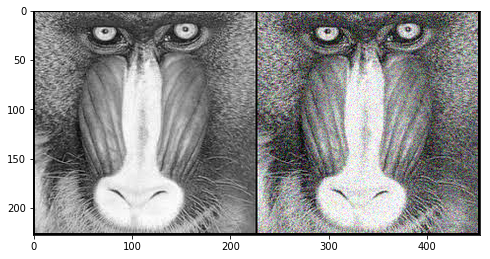

(3, 224, 224)


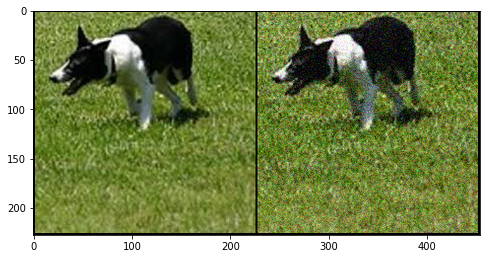

(3, 224, 224)


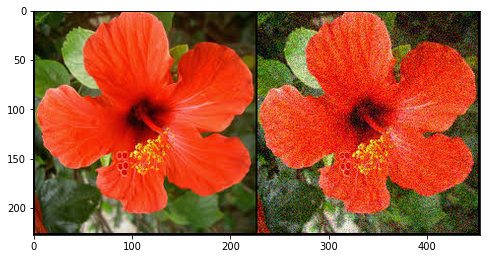

(3, 256, 256)


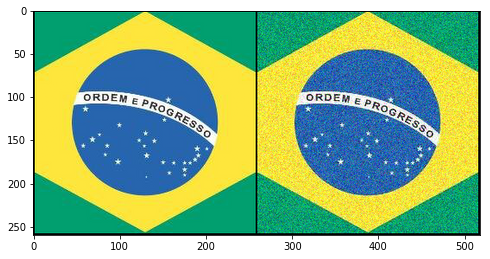

(3, 256, 256)


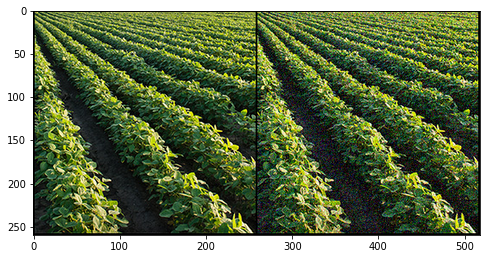

(3, 256, 256)


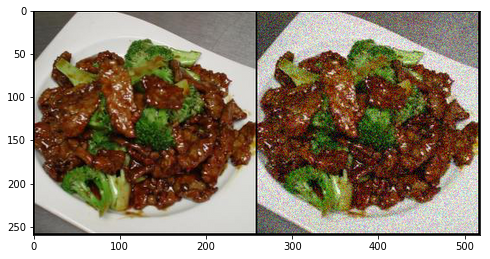

(3, 224, 224)


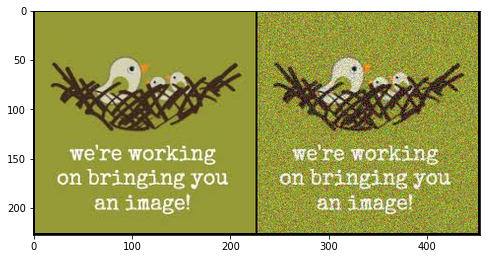

(3, 256, 256)


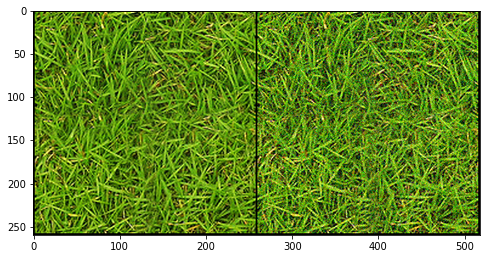

(3, 224, 224)


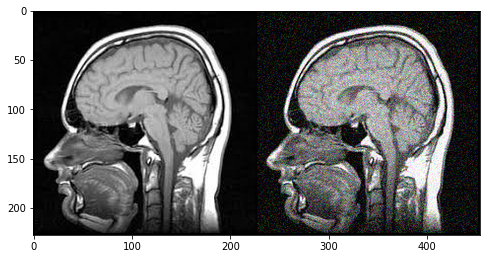

(3, 224, 224)


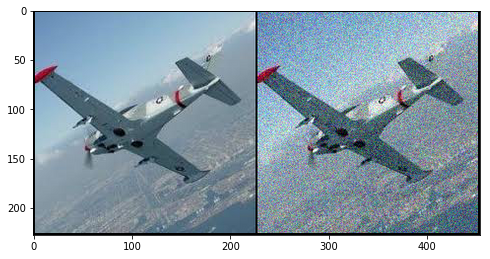

(3, 256, 256)


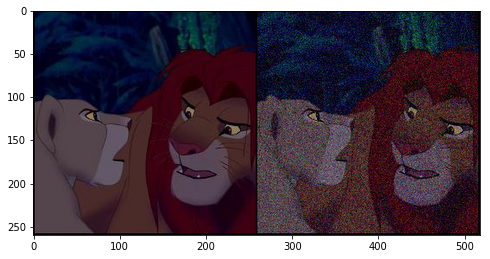

(3, 256, 256)


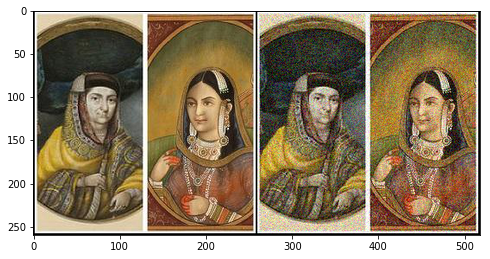

(3, 256, 160)


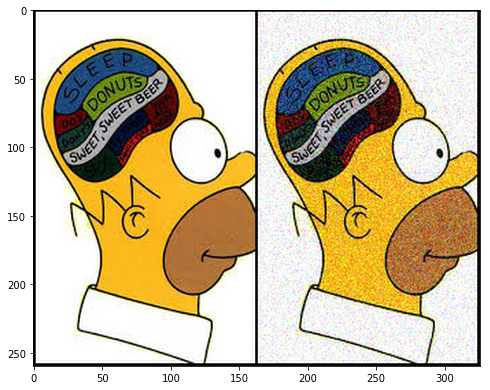

In [2]:
from os import listdir
from os.path import isfile, join

directory = "/home/justin/Github/deep-image-prior/data/denoising/test_images/"
filenames = [f for f in listdir(directory) if isfile(join(directory, f))]
numimages = len(filenames)

img_pils = []; img_nps = []
img_noisy_pils = []; img_noisy_nps = []

# Add synthetic noise

for filename in filenames:
    fname = directory+filename
    img = get_image(fname, imsize)


    img_pil = crop_image(img[0], d=32)
    img_np = pil_to_np(img_pil)
    print(img_np.shape)
    img_noisy_pil, img_noisy_np = get_noisy_image(img_np, sigma_)

    img_pils.append(img_pil); img_nps.append(img_np)
    img_noisy_pils.append(img_noisy_pil); img_noisy_nps.append(img_noisy_np)

    if PLOT:
        plot_image_grid([img_np, img_noisy_np], 4, 6);

In [3]:
num = 3
img_pil = img_pils[num]
img_np = img_nps[num]
img_noisy_pil = img_noisy_pils[num]
img_noisy_np = img_noisy_nps[num]

# Setup

In [4]:
INPUT = 'noise' # 'meshgrid'
pad = 'reflection'
OPT_OVER = 'net' # 'net,input'

# reg_noise_std = 1./30. # set to 1./20. for sigma=50
reg_noise_std = 0.0 # set to 1./20. for sigma=50
LR = 0.01

OPTIMIZER='adam' # 'LBFGS'
show_every = 100
exp_weight=0.99

num_iter = 3000
input_depth = 32 
figsize = 4 


net = get_net(input_depth, 'skip', pad,
              skip_n33d=128, 
              skip_n33u=128, 
              skip_n11=4, 
              num_scales=5,
              upsample_mode='bilinear').type(dtype)

    
net_input = get_noise(input_depth, INPUT, (img_pil.size[1], img_pil.size[0])).type(dtype).detach()

# Compute number of parameters
s  = sum([np.prod(list(p.size())) for p in net.parameters()]); 
print ('Number of params: %d' % s)

# Loss
mse = torch.nn.MSELoss().type(dtype)

img_noisy_torch = np_to_torch(img_noisy_np).type(dtype)

Number of params: 2217831


# Optimize

Starting optimization with ADAM


/home/justin/Programs/anaconda3/envs/deep-image-prior/lib/python3.6/site-packages/torch/nn/functional.py:1749: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


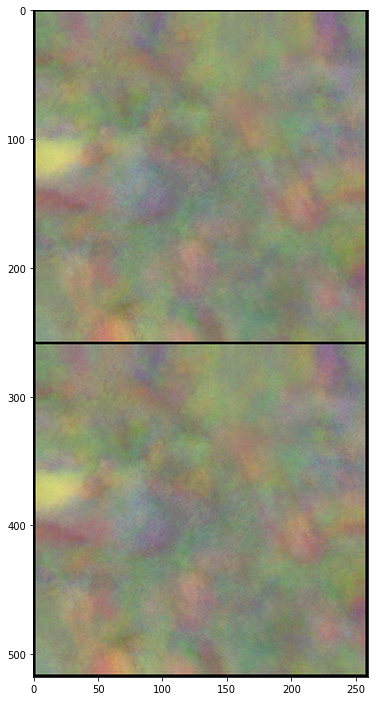

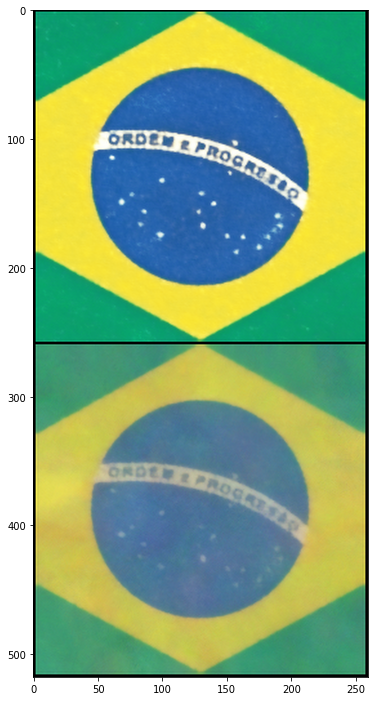

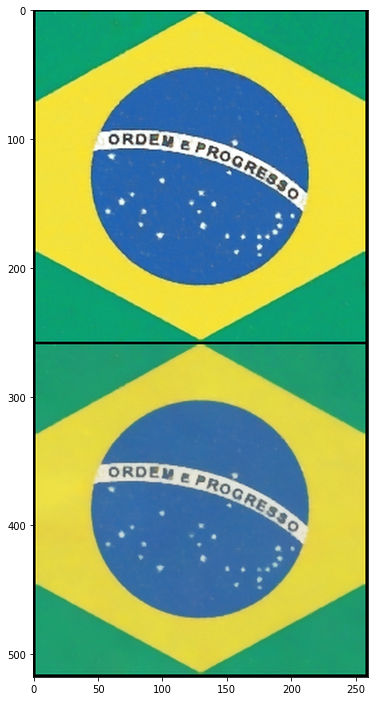

KeyboardInterrupt: 

In [5]:
net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()
out_avg = None
last_net = None
psrn_noisy_last = 0

i = 0
def closure():
    
    global i, out_avg, psrn_noisy_last, last_net, net_input
    
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)
    
    out = net(net_input)
    
    # Smoothing
    if out_avg is None:
        out_avg = out.detach()
    else:
        out_avg = out_avg * exp_weight + out.detach() * (1 - exp_weight)
            
    total_loss = mse(out, img_noisy_torch)
    total_loss.backward()
        
    
    psrn_noisy = compare_psnr(img_noisy_np, out.detach().cpu().numpy()[0]) 
    psrn_gt    = compare_psnr(img_np, out.detach().cpu().numpy()[0]) 
    psrn_gt_sm = compare_psnr(img_np, out_avg.detach().cpu().numpy()[0]) 
    
    # Note that we do not have GT for the "snail" example
    # So 'PSRN_gt', 'PSNR_gt_sm' make no sense
    print ('Iteration %05d    Loss %f   PSNR_noisy: %f   PSRN_gt: %f PSNR_gt_sm: %f' % (i, total_loss.item(), psrn_noisy, psrn_gt, psrn_gt_sm), '\r', end='')
    if  PLOT and i % show_every == 0:
        out_np = torch_to_np(out)
        plot_image_grid([np.clip(out_np, 0, 1), 
                         np.clip(torch_to_np(out_avg), 0, 1)], factor=figsize, nrow=1)
        
        
    
    # Backtracking
    if i % show_every:
        if psrn_noisy - psrn_noisy_last < -5: 
            print('Falling back to previous checkpoint.')

            for new_param, net_param in zip(last_net, net.parameters()):
                net_param.detach().copy_(new_param.cuda())

            return total_loss*0
        else:
            last_net = [x.detach().cpu() for x in net.parameters()]
            psrn_noisy_last = psrn_noisy
            
    i += 1

    return total_loss

p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter)

In [ ]:
out_np = torch_to_np(net(net_input))
q = plot_image_grid([np.clip(out_np, 0, 1), img_np], factor=13);

In [ ]:
# Random Walk through latent space
num_steps = 10
epsilon = 100
shape = net_input.shape

for _ in range(0,num_steps):
    previous = net_input
    step = np.random.randn(*shape)
    SUM = np.sum(step)
    step = torch.tensor(epsilon/SUM*step).type(dtype)
    net_input = torch.add(net_input,step)
    diff = np.subtract(torch_to_np(net_input),torch_to_np(previous))
    out = net(net_input)
    out_np = torch_to_np(out)
    plt.imshow(out_np.transpose(1, 2, 0))
    plt.show()

# # Random Latent Code
# step = np.random.randn(*shape)
# new_net_input = torch.tensor(step).type(dtype)
# out = net(net_input)
# out_np = torch_to_np(out)
# plt.imshow(out_np.transpose(1, 2, 0))
# plt.show()
